In [1]:
import link_bot_classifiers
from link_bot_data.new_classifier_dataset import NewClassifierDataset
from link_bot_planning.params import LocalEnvParams
from link_bot_classifiers.visualization import plot_classifier_data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import json

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
n_batch = 1

path = pathlib.Path("classifier_data/10_link_planning2-classifier/")
test_dataset = NewClassifierDataset([path])
test_tf_dataset = test_dataset.get_datasets(mode='test',
                                            shuffle=False,
                                            seed=0,
                                            batch_size=n_batch,
                                            balance_key=None)

###############
# Model
###############
checkpoint = pathlib.Path("log_data/1conv_3x3/January_19_14-26-57_91981ec697")
model_hparams = json.load((checkpoint / 'hparams.json').open('r'))
module = link_bot_classifiers.get_model_module(model_hparams['model_class'])
net = module.model(model_hparams)

sequence length not specified, assuming hparams sequence length: 50


In [4]:
hparams = model_hparams['classifier_dataset_hparams']
n_state =  hparams['n_state']
local_env_params = LocalEnvParams.from_json(hparams['local_env_params'])
h = local_env_params.h_rows
w = local_env_params.w_cols
build_data = {
    'planned_state': tf.zeros((n_batch, n_state), dtype=tf.float32),
    'planned_state_next': tf.zeros((n_batch, n_state), dtype=tf.float32),
    'planned_local_env/env': tf.zeros((n_batch, h, w), dtype=tf.float32),
    'planned_local_env/origin': tf.zeros((n_batch, 2), dtype=tf.float32),
    'planned_local_env/extent': tf.zeros((n_batch, 4), dtype=tf.float32),
    'resolution': tf.zeros((n_batch, 1), dtype=tf.float32),
}
i1, i2, env, p = net(build_data)

In [5]:
conv_w, conv_b, linear_w, linear_b = net.get_weights()
n_conv = conv_w.shape[2]
for w in net.get_weights():
    print(w.shape)

(3, 3, 23, 1)
(1,)
(576, 1)
(1,)


In [6]:
print("conv_b {}".format(conv_b[0]))
print("linear_b {}".format(linear_b[0]))

conv_b 0.0
linear_b 0.0


/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


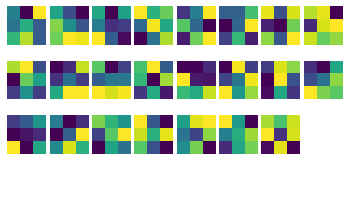

In [116]:
aspect=2
nrows = int(np.ceil(np.sqrt(n_conv / aspect)))
ncols = int(np.ceil(aspect * nrows))
fig, axes = plt.subplots(nrows, ncols, gridspec_kw = {'wspace': 0.1, 'hspace':0})
for idx in range(n_conv):
    r, c = np.unravel_index(idx, [nrows, ncols])
    axes[r, c].imshow(conv_w[:, :, idx, 0])
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

plt.tight_layout();

In [115]:
print(np.min(conv_w))
print(np.max(conv_w))

-0.16610305
0.16590472


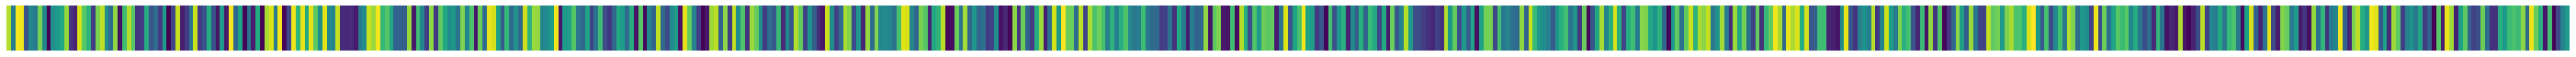

In [8]:
plt.figure(figsize=(50,1))
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
ax.imshow(linear_w.T, aspect=10.0);

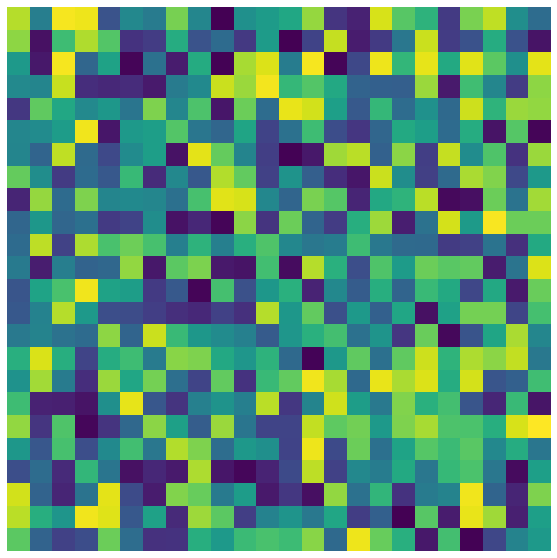

In [9]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
ax.imshow(linear_w.reshape(24,24), aspect='equal');

In [142]:
for example in test_tf_dataset:
    print(example['label'])
    if example['label'].numpy()[0] == 1:
        if example['planned_local_env/env'].numpy().sum() >= 0:
            break
for k, v in example.items():
    print(k, v.shape)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
resolution_next (1, 1)
resolution (1, 1)
actual_local_env_next/origin (1, 2)
actual_local_env/origin (1, 2)
actual_local_env_next/extent (1, 4)
actual_local_env/extent (1, 4)
actual_local_env_next/env (1, 50, 50)
actual_local_env/env (1, 50, 50)
planned_local_env_next/origin (1, 2)
planned_local_env/origin (1, 2)
planned_local_env_next/extent (1, 4)
planned_local_env/extent (1, 4)
planned_local_env_next/env (1, 50, 50)
planned_local_env/env (1, 50, 50)
state_next (1, 22)
state (1, 22)
planned_state_next (1, 22)
planned_state (1, 22)
action (1, 2)
local_env_rows (1, 1)
local_env_cols (1, 1)
pre_dist (1, 1)
post_dist (1, 1)
pre_close (1, 1)
label (1, 1)


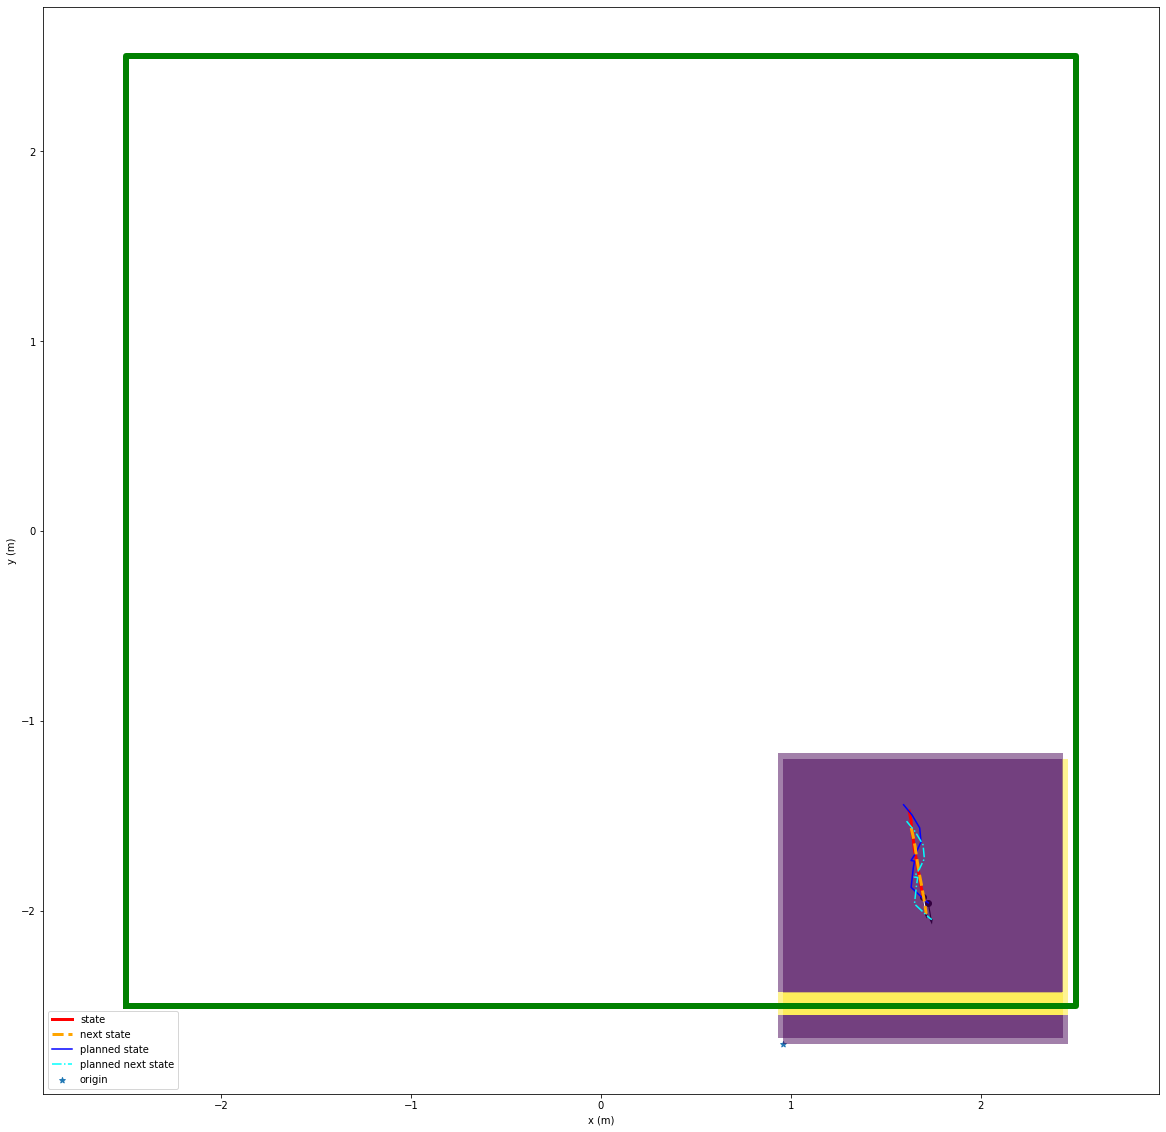

In [143]:
res = example['resolution'].numpy().squeeze()
res = np.array([res, res])
planned_local_env = example['planned_local_env/env'].numpy().squeeze()
planned_local_env_extent = example['planned_local_env/extent'].numpy().squeeze()
planned_local_env_origin = example['planned_local_env/origin'].numpy().squeeze()
actual_local_env = example['actual_local_env/env'].numpy().squeeze()
actual_local_env_extent = example['actual_local_env/extent'].numpy().squeeze()
state = example['state'].numpy().squeeze()
action = example['action'].numpy().squeeze()
next_state = example['state_next'].numpy().squeeze()
planned_state = example['planned_state'].numpy().squeeze()
planned_next_state = example['planned_state_next'].numpy().squeeze()
label = example['label'].numpy().squeeze()


plt.figure(figsize=(20,20))
ax = plt.gca()
plot_classifier_data(ax=ax,
                     next_state=next_state,
                     action=action,
                     planned_next_state=planned_next_state,
                     planned_env=planned_local_env,
                     planned_env_extent=planned_local_env_extent,
                     planned_state=planned_state,
                     planned_env_origin=planned_local_env_origin,
                     res=res,
                     state=state,
                     actual_env=actual_local_env,
                     actual_env_extent=actual_local_env_extent,
                     label=label)
plt.show()

In [144]:
i1_, i2_, env, p = net(example)

(50, 50, 11)


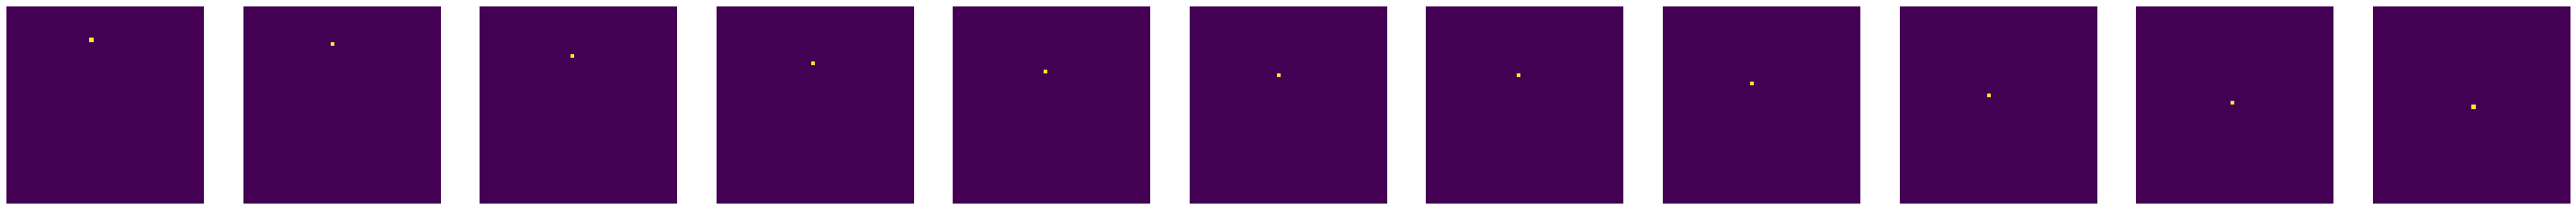

In [145]:
i1 = i1_.numpy().squeeze()
i2 = i2_.numpy().squeeze()
n_channels = i1.shape[2]
print(i1.shape)
fig, axes = plt.subplots(1, n_channels, figsize=(50,10))
for channel in range(n_channels):
    axes[channel].imshow(np.flipud(i1[:, :, channel]), aspect='equal')
    axes[channel].set_xticks([])
    axes[channel].set_yticks([])
    axes[channel].axis("off")

In [146]:
planned_rope_image, planned_next_rope_image, planned_local_env, concat_image_ = net._image(example)
concat_image = concat_image_.numpy().squeeze()

In [147]:
concat_image.shape

(50, 50, 23)

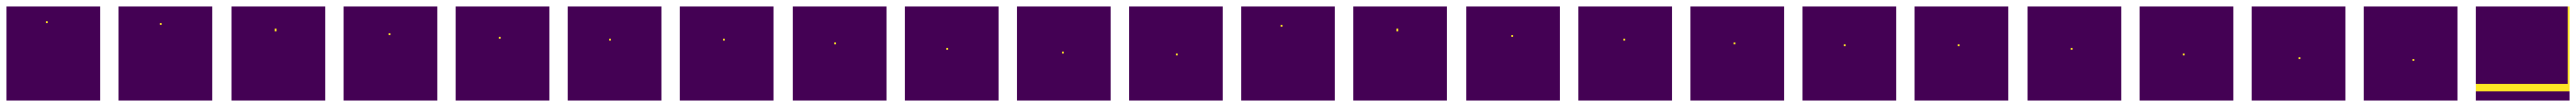

In [148]:
n_channels = concat_image.shape[2]
fig, axes = plt.subplots(1, n_channels, figsize=(50,10))
for channel in range(n_channels):
    axes[channel].imshow(np.flipud(concat_image[:, :, channel]), aspect='equal')
    axes[channel].set_xticks([])
    axes[channel].set_yticks([])
    axes[channel].axis("off")

In [149]:
conv_z_ = net._conv(concat_image_)
conv_z = conv_z_.numpy().squeeze()

In [150]:
conv_z.shape

(24, 24)

In [151]:
print(np.max(conv_z))
print(np.min(conv_z))

0.5462688
0.0


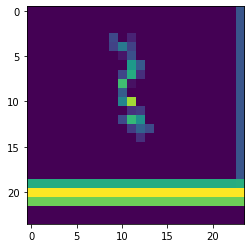

In [152]:
plt.imshow(np.flipud(conv_z))

In [153]:
tf.sigmoid(conv_z.flatten() @ linear_w).numpy()[0] > 0.5

True